In [24]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

import plotly as ply

import tqdm
import gc
import sys
import os

import scipy as sp

import json

%cd /data/lyna/Milestone_Error_Analysis_Testing
import analysis_functions

/data/lyna/Milestone_Error_Analysis_Testing


In [25]:
def potFun(x):
    return(0.1*((1/2000)*(x)**6-(x)**2))
def potGradFun(x):
    return(0.1*((6.0/2000)*(x)**5-2.0*(x)))

def gen_harmonic_window_potFun(potFun,win_center,kval):
    return(
        lambda x: potFun(x)+.5*kval*(x-win_center)**2
    )
def gen_harmonic_window_potGradFun(potGradFun,window_center,kval):
    return(
        lambda x: potGradFun(x)-kval*(window_center-x)
    )

def only_harmonic_window_potFun(potFun,win_center,kval):
    return(
        lambda x: potFun(x)+.5*kval*(x-win_center)**2
    )
def only_harmonic_window_potGradFun(potGradFun,window_center,kval):
    return(
        lambda x: potGradFun(x)-kval*(window_center-x)
    )

In [26]:
# Setup US potential

# Setup Umbrella sampling potential

binEdges=np.linspace(-8,8,9)
binCenters=(binEdges[:-1]+binEdges[1:])/2.

symm_window_centers=binCenters
symm_window_kVals=np.array([1.]*len(symm_window_centers)) # US force constant 100-fold smaller for overlapping

#centerdict={"centers":symm_window_centers,"k":symm_window_kVals}
#centersDat=pd.DataFrame(data=centerdict)
#print(centersDat)
#centersDat.to_csv("/data/lyna/BD-milestoning-test/debug/centers.dat",index=False)

symm_window_potFuns=[
    gen_harmonic_window_potFun(potFun, window_center,wk) \
    for window_center,wk in np.array([
        symm_window_centers,
        symm_window_kVals
    ]).T
]

symm_window_potGradFuns=[
    gen_harmonic_window_potGradFun(potGradFun,window_center,wk) \
    for window_center,wk in np.array([
        symm_window_centers,
        symm_window_kVals
    ]).T
]

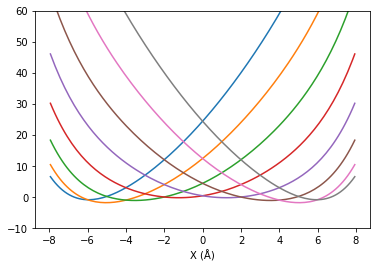

In [27]:
# Check US potentials before running BD

winPot=[]
winPotGrad=[]
for win in np.arange(0,len(symm_window_centers)):
    winPot=symm_window_potFuns[win]
    winPotGrad=symm_window_potGradFuns[win]
    
    binEdges=np.linspace(-8,8,130)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters

    sns.lineplot(
        x=xgrid,
        y=winPot(xgrid)
        #label='symm_win_%02g_U(x)'%win
    )


plt.xlabel('X (Å)')
plt.ylim(-10,60)
plt.show()

In [28]:
# Run US

diffCoef=.0282*310.15/298.15
kb=0.001985875
Tsim=310.15
kbT=kb*Tsim
print("kbT",kbT, )
print("symm_window_centers",symm_window_centers)

symm_win_sim_data=[]
for iWin,winCenter in enumerate(symm_window_centers):
    win_potGradFun=symm_window_potGradFuns[iWin]
    bd_Sim=analysis_functions.Simple_1D_BD_Sim(win_potGradFun)
    bd_Sim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=10,
        verbose=True,
        timestep=0.5
    ))
    bd_Sim.set_x0(winCenter)

    nsteps=500000 #500k steps x8 windows x 0.5 fs= 2 us, sufficeint to converge brute-force BD
    symm_win_sim_data.append(bd_Sim.run_sim(nsteps=nsteps,giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps)))
    trajData=symm_win_sim_data[iWin]
    binEdges=np.linspace(-8,8,130)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters
    sns.distplot(trajData['trajectory'],bins=binEdges, color=None)

plt.xlabel('X (Å)')
plt.show()

kbT 0.6159191312499999
symm_window_centers [-7. -5. -3. -1.  1.  3.  5.  7.]


TypeError: 'tuple' object is not callable

In [37]:
trajData

{'trajectory': array([7.        , 5.96734466, 6.00785279, ..., 5.49457344, 5.54918318,
        5.98087003]),
 'velocities': array([ 0.02670372, -0.15099128, -0.00134807, ..., -0.13347645,
        -0.18698071,  0.        ])}

In [ ]:
# Save US data for mbar and wham

for iWin,winData in enumerate(symm_win_sim_data):
    stepsPerWindow=(len(winData['trajectory']))
print(stepsPerWindow)

milestone_data_table=pd.DataFrame({
    'Window':(np.array([[iWin]*len(winData['trajectory']) for iWin,winData in enumerate(symm_win_sim_data)])).flatten(),
    'X':(np.array([winData['trajectory'] for winData in symm_win_sim_data])).flatten(),
    "WindowCenter":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])).flatten()),
    #"WindowLeft":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])-1.5).flatten()),
    #"WindowRight":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])+1.5).flatten()),
})
milestone_data_table['X_Ind']=milestone_data_table['X'].map(lambda x: np.argmin(np.abs(x-symm_window_centers)))
milestone_data_table
milestone_data_table.to_csv('data_window.csv',index=False)

In [23]:
import pymbar
from pymbar import timeseries
!python3 --version
import numpy
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact,interact_manual

import tqdm

Python 3.7.5


In [24]:
#kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K
kB=0.001985875 #kcal/(mol*K)
temperature = 310.15 # assume a single temperature -- can be overridden with data from center.dat 

K = 8 # number of umbrellas
N_max = 500000 # maximum number of snapshots/simulation
T_k = numpy.ones(K,float)*temperature # inital temperatures are all equal 
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))
z_min = -8.0 # min for PMF
z_max = 8.0 # max for PMF
nbins = 29 # number of bins for 1D PMF

In [32]:
# Allocate storage for simulation data
N_k = numpy.zeros([K], numpy.int32) # N_k[k] is the number of snapshots from umbrella simulation k
K_k = numpy.zeros([K], numpy.float64) # K_k[k] is the spring constant (in kJ/mol/deg**2) for umbrella simulation k
z0_k = numpy.zeros([K], numpy.float64) # chi0_k[k] is the spring center location (in deg) for umbrella simulation k
z_kn = numpy.zeros([K,N_max], numpy.float64) # chi_kn[k,n] is the torsion angle (in deg) for snapshot n from umbrella simulation k
u_kn = numpy.zeros([K,N_max], numpy.float64) # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
g_k = numpy.zeros([K],numpy.float32);

In [33]:
%cd /data/lyna/BD-milestoning-test/debug
!ls 
infile = open('/data/lyna/BD-milestoning-test/debug/centers.dat', 'r')
lines = infile.readlines()
infile.close()
for k in range(K):
    line = lines[k]
    tokens = line.split(",")
    z0_k[k] = float(tokens[0]) # spring center locatiomn 
    K_k[k] = float(tokens[1]) # spring constant   
    print(k,z0_k[k],K_k[k])
    if len(tokens) > 2:
        T_k[k] = float(tokens[2])  # temperature the kth simulation was run at.

/data/lyna/BD-milestoning-test/debug
BD-US-testcase.ipynb   centers.dat	      oneRep-Escape-Reentry.csv
USvsMilestoning.ipynb  data_window.csv	      setup_windows.csv
analysis_functions.py  milestone-debug.ipynb
0 -7.0 1.0
1 -5.0 1.0
2 -3.0 1.0
3 -1.0 1.0
4 1.0 1.0
5 3.0 1.0
6 5.0 1.0
7 7.0 1.0


In [ ]:
beta_k = 1.0/(kB*T_k)   # beta factor for the different temperatures
DifferentTemperatures = True
if (min(T_k) == max(T_k)):
    DifferentTemperatures = False            # if all the temperatures are the same, then we don't have to read in energies.
# Read the simulation data
for k in range(K):
    # Read torsion angle data.
    filename = 'data/step5.%02d.3_pmfSetup.dat.z' % k
    print ("Reading %s..." % filename)
    infile = open(filename, 'r')
    lines = infile.readlines()
    infile.close()
    # Parse data.
    n = 0
    for line in lines:
        if line[0] != 'c':
            tokens = line.split(" ")
            chi_kn[k,n] = float(tokens[1]) # torsion angle
            n += 1
    N_k[k] = n
   